In [15]:
import numpy as np
import sys
sys.path.append("..")
import helper.helper as h
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoLars
# import helper.methods as m

### Load data set

[[ 0.    0.    0.    0.43  0.    0.    0.    0.    0.    0.  ]
 [-0.29  0.    0.    0.27 -0.3  -0.29  0.    0.    0.   -0.35]
 [ 0.    0.    0.   -0.42  0.    0.    0.    0.    0.37  0.  ]
 [ 0.   -0.27  0.46 -0.4  -0.41  0.    0.    0.    0.42  0.  ]
 [ 0.    0.    0.48  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.34  0.    0.    0.    0.    0.   -0.41  0.    0.    0.29]
 [-0.43  0.    0.    0.    0.28  0.    0.    0.46  0.    0.  ]
 [-0.44  0.   -0.26  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.41 -0.48 -0.5   0.26  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.47  0.    0.    0.32  0.    0.3   0.27]]


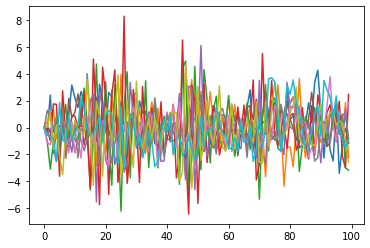

In [16]:
# Get data name
T, n = 100, 3
data_name = "X_s30_n10_T100_random_matrix_0"
W = np.array([[0.5, -0.65, 0.0], [0.0, 0.50, -0.25], [0.0, 0.0, 0.40]])
# W = np.random.rand(n, n) / n
X = h.generate_var_2(T, n, W, np.identity(n))

# Load data
W, X, expl = h.load_data(data_name)

# Plot data
plt.plot(X)

# Show true matrix W
print(np.round(W, 2))

# Show explanation
# print(expl)

# Useful variables
T, n = np.shape(X)

In [17]:
def lasso_lars_W(X, alpha):
    """Performs LASSO with Lars on X with regularization value alpha"""
    
    # get regressor and variables
    y = X[1:]
    x = X[:-1]

    # initialize W_hat
    W_hat = np.array([])

    # Get our regularization method
    reg = LassoLars(alpha=alpha, normalize=False)
    
    # get parameters
    for i in range(n):
        est = reg.fit(x, y[:, i])
        W_hat = np.append(W_hat, est.coef_)

    # return W_hat after reshape
    return W_hat.reshape((n, n)).T

In [18]:
def lingnam_lasso_lars(X, step_size = 0.1):
    """Incrementally increase penalty by step_size until we have aa DAG"""
    
    # initial L1 penalty
    alpha = 0.0
    
    # get W_hat with 0 penalty -> OLS
    W_ols = lasso_lars_W(X, alpha)
    W_hat = W_ols.copy()
    
    # while we do not have a dag
    while not h.is_dag(W_hat):
        # increase alpha and do lasso with increased alpha
        alpha += step_size
        W_hat = lasso_lars_W(X, alpha)

    # return W_hat and print smallest alpha
    print(f"Smallest alpha for DAG: {round(alpha, 5)}.")
    return W_hat

### Lingnam LASSO on data

In [19]:
# Perform Lingnam LASSO on Data
# Get smallest lambda for which G(W) is a DAG
# Return this DAG
print(lasso_lars_W(X, 0.1))

[[-2.51879843e-02  0.00000000e+00  1.89768885e-02  4.63766593e-01
   0.00000000e+00  8.16387440e-02 -1.80411123e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.18057246e-01  6.74355455e-02  0.00000000e+00  3.44491795e-01
  -3.96163192e-01 -2.01751564e-01  0.00000000e+00  8.54742637e-02
   0.00000000e+00 -4.56271351e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.01221438e-01
   0.00000000e+00 -1.18725128e-02  0.00000000e+00  0.00000000e+00
   3.39644370e-01  0.00000000e+00]
 [-2.03211701e-05 -2.61793000e-01  4.64915098e-01 -2.52927769e-01
  -4.06055393e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   4.19648148e-01  2.08981347e-02]
 [-2.13492144e-02  0.00000000e+00  4.17780227e-01  5.26889265e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  4.54728447e-02
   0.00000000e+00  0.00000000e+00]
 [ 3.26819313e-01  0.00000000e+00  0.00000000e+00 -7.20932664e-02
   4.82061872e-02  8.56469198e-03 -3.74470527e-01  0.00000000e+00
   0.00000000e+00  1.96009602e-01

### Function to get solution path

In [20]:
def get_evolution_lasso(X, step_size = 0.2):
    """Returns the evolution paths for lasso with X as data"""
    
    # solution paths will be saved here
    results, alphas, coefs_zero = [], [], []
    
    # initial L1 penalty
    alpha = 0.0
    
    # get W_hat with 0 penalty -> OLS
    W_ols = lasso_lars_W(X, alpha)
    W_hat = W_ols.copy()
    
    # get number of non-zero coefficients for this value
    non_zero_coefs = W_hat.copy().flatten()
    non_zero_coefs[non_zero_coefs != 0] = 1
    
    # append the values of this iteration
    coefs_zero.append(non_zero_coefs)
    results.append(W_hat.flatten())
    alphas.append(alpha)
    
    # for simplicity I assume we have no DAG for OLS
    # else this approach is not meaningful anyway
    dag_yet, dag_alpha = False, 0
    
    # while we have non-zero coefficients
    while len(W_hat[W_hat != 0]) > 0:
        
        # perform lasso with increased step size
        alpha += step_size
        W_hat = lasso_lars_W(X, alpha)
        
        # get new nonzero coefficients
        non_zero_coefs = W_hat.copy().flatten()
        non_zero_coefs[non_zero_coefs != 0] = 1
        
        # check if we have found smallest lambda that makes a DAG        
        if h.is_dag(W_hat) and not dag_yet:
            dag_alpha = alpha
            dag_yet = True
        
        # append results
        results.append(W_hat.flatten())
        coefs_zero.append(non_zero_coefs)    
        alphas.append(alpha)
    
    # for nicer plot, last part of all zero plotted
    alpha *= 1.2
    W_hat = lasso_lars_W(X, alpha)
    
    # number of non-zero coefficents should be all
    non_zero_coefs = W_hat.copy().flatten()
    non_zero_coefs[non_zero_coefs != 0] = 1
    
    # append last results
    results.append(W_hat.flatten())
    coefs_zero.append(non_zero_coefs)
    alphas.append(alpha)
        
    # return results
    return results, alphas, coefs_zero, dag_alpha

### Get the solution paths + Preprocessing for plot

In [21]:
# get results
results, alphas, coefs_zero, dag_alpha = get_evolution_lasso(X, step_size = 0.005)

# get points for which each coefficient is zero
zero_points = []

for i in range(len(coefs_zero[0])):
    zero_points.append(alphas[np.argmin(np.array(coefs_zero)[:,i])])

# get order of coefficients based on "strength"
order = np.argsort(zero_points)

# convert to numpy array for column accessibility
results = np.array(results)

# remove this, as we have a special color for this one
zero_points.remove(dag_alpha)

### Plot the solution path

In [8]:
# import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "xelatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
#     'font.size': 8
# })

Smallest alpha for DAG: 3.809.
Estimated W at blue vertical line:
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.14  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]].

True W:
[[ 0.          0.          0.          0.43194109  0.          0.
   0.          0.          0.          0.        ]
 [-0.29288096  0.          0.          0.27344301 -0.30046064 -0.28689958
   0.          0.          0.         -0.34901154]
 [ 0.          0.          0.         -0.4211574   

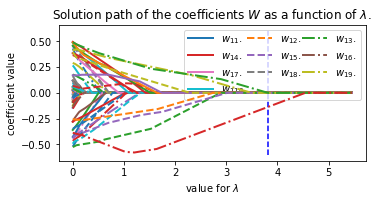

In [9]:
# Figure with title and labels
plt.figure(figsize=(5.5, 2.5))
plt.title(r"Solution path of the coefficients $W$ as a function of $\lambda$.")
plt.xlabel(r'value for $\lambda$')
plt.ylabel('coefficient value')
labels = [f"$w_{{{i + 1}{j + 1}}}$." for i in range(n) for j in range(n)]
linestyles = ['-', '--', '-.']

# Plot solution paths
for i in range(len(results[0])):
    if results[0][i] != 0:
        plt.plot(alphas, results[:, i], linewidth = 2.0, zorder = np.where(order == i)[0], label = labels[i], linestyle = linestyles[i % 3])

# Plot lambda for which coefficients fade away
# plt.vlines(zero_points, -(np.max(np.abs(W)) + 0.1) * np.ones(len(zero_points)), (np.max(np.abs(W)) + 0.1) * np.ones(len(zero_points)), linestyle='--', linewidth = 1.5)

# Lambda for which G(W) is a dag is green and thicker
plt.vlines(dag_alpha, -(np.max(np.abs(W)) + 0.1), (np.max(np.abs(W)) + 0.1), linestyle = '--', colors = ['blue'], linewidth = 1.5, label = r'$\lambda^*$')

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [0, 3, 6, 9, 1, 4, 7, 2, 5, 8]

# Plot with legend
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=1, handlelength = 2.5, ncol = 3, columnspacing = 0.05)
plt.savefig('LASSOpath2_v2.pgf', bbox_inches = 'tight')
# plt.show()

# Print estimated W and true W
print(f"Estimated W at blue vertical line:\n{np.round(lingnam_lasso_lars(X, 0.001), 2)}.\n")
print(f"True W:\n{W}.")

In [10]:
print(np.shape(X))

(100, 10)


In [11]:
# h.save_data(X, W, "LASSO_example", "time series used in the LASSO example with model mismatch.")

In [12]:
def lasso_lars_W(X, alpha):
    """Performs LASSO with Lars on X with regularization value alpha"""
    
    # get regressor and variables
    y = X[1:]
    x = X[:-1]

    # initialize W_hat
    W_hat = np.array([])

    # Get our regularization method
    reg = LassoLars(alpha=alpha, normalize=False, fit_intercept=False)
    
    # get parameters
    est = reg.fit(x, y)

    # return W_hat after reshape
    return est.coef_.T

In [13]:
def lasso_lars_W2(X, alpha):
    
    T, p = np.shape(X)

    X_large = np.kron(np.eye(p, dtype=float), X[:-1])
    y_large = X[1:].T.reshape((T - 1) * p, 1)
                
    clf = LassoLars(alpha=alpha, normalize=False, fit_intercept = False)
    clf.fit(X_large, y_large)
    
    return clf.coef_.reshape(p, p).T

print(lasso_lars_W(X, 0.5))
print(lasso_lars_W2(X, 0.5 / n))

[[ 0.          0.          0.          0.31586301  0.          0.
   0.          0.          0.          0.        ]
 [-0.19243011  0.          0.          0.22713001 -0.24454659 -0.05418483
   0.          0.          0.         -0.32090997]
 [ 0.          0.          0.         -0.46513849  0.          0.
   0.          0.          0.27448473  0.        ]
 [ 0.         -0.24240028  0.39143496 -0.14533225 -0.32679471  0.
   0.          0.          0.36594897  0.        ]
 [ 0.          0.          0.3018776   0.07620524  0.          0.
   0.          0.          0.          0.        ]
 [ 0.02940755  0.          0.          0.          0.          0.
  -0.06256212  0.          0.          0.        ]
 [-0.11598529  0.          0.          0.          0.15608732  0.
   0.          0.15005734  0.          0.        ]
 [-0.20022723  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.29507616 -0.46599772 -0.24997271  0.192

In [14]:
help(LassoLars)

Help on class LassoLars in module sklearn.linear_model._least_angle:

class LassoLars(Lars)
 |  Lasso model fit with Least Angle Regression a.k.a. Lars
 |  
 |  It is a Linear Model trained with an L1 prior as regularizer.
 |  
 |  The optimization objective for Lasso is::
 |  
 |  (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1
 |  
 |  Read more in the :ref:`User Guide <least_angle_regression>`.
 |  
 |  Parameters
 |  ----------
 |  alpha : float, default=1.0
 |      Constant that multiplies the penalty term. Defaults to 1.0.
 |      ``alpha = 0`` is equivalent to an ordinary least square, solved
 |      by :class:`LinearRegression`. For numerical reasons, using
 |      ``alpha = 0`` with the LassoLars object is not advised and you
 |      should prefer the LinearRegression object.
 |  
 |  fit_intercept : bool, default=True
 |      whether to calculate the intercept for this model. If set
 |      to false, no intercept will be used in calculations
 |      (i.e. data is exp